In [21]:
import urllib.request 
from json import *
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib.dates as mdates
from sklearn import svm, preprocessing, cross_validation, grid_search, linear_model, naive_bayes, metrics
from sklearn.learning_curve import learning_curve
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Data from Fantasy Premier League API

u = "http://fantasy.premierleague.com/web/api/elements/4"
x1 = urllib.request.urlopen(u).read().decode()
dic = {}
dic = JSONDecoder().decode(x1)
print(dic)

playerGameweek_df = pd.DataFrame(dic['fixture_history']['all'])
playerGameweek_df.columns = ['Date','Round','Opponent','Minutes_Played','Goals_Scored','Assists','Clean_Sheets',
                             'Goals_Conceded','Own_goals','Penalties_Saved','Penalties_Missed',
                             'Yellow_Cards','Red_Cards','Saves','Bonus','PPI','BonusPS','Net_Transfers',
                             'Player_Value','Points']
playerGameweek_df.set_index('Round', inplace=True, drop=True)

playerPreviousSeason_df = pd.DataFrame(dic['season_history'])
playerPreviousSeason_df.columns = ['Year','Minutes_Played','Goals_Scored','Assists','Clean_Sheets',
                             'Goals_Conceded','Own_goals','Penalties_Saved','Penalties_Missed',
                             'Yellow_Cards','Red_Cards','Saves','Bonus','PPI','BonusPS','Player_Value','Points']
#playerPreviousSeason_df.set_index('Year', inplace=True, drop=True)

playerGenInfor_df = pd.Series()
dicIndex = ['type_name','first_name','web_name','team_name', 'dreamteam_count'
            ,'chance_of_playing_this_round','selected_by_percent', 'next_fixture']
for index in dicIndex:
    joiner = pd.Series(dic[index], name = str(index))
    playerGenInfor_df = pd.concat([playerGenInfor_df,joiner], axis = 1)

print(playerGenInfor_df.head(5))
print(playerPreviousSeason_df.head(5))
print(playerGameweek_df.head(5))

In [2]:
#Data from Premier League Website

def league_table(season, month, tm, club = 'All'):
    tmUnix = time.mktime(dt.datetime.strptime(tm, '%d/%m/%y').timetuple())
    tmUnix = str(tmUnix*1000)
    url = 'http://www.premierleague.com/en-gb/matchday/league-table.html?season='+season+'&month='+month+'&timelineView=date&toDate='+tmUnix+'&tableView=HOME_VS_AWAY'
    df = pd.read_html(url)
    df = pd.DataFrame(df[0])
    table = pd.DataFrame(df)
    col_names = ['Pos', 'CLUB', 'HP', 'HW', 'HD', 'HL', 'HGF', 'HGA', 'HGD', 'HPTS', 'AP', 'AW', 'AD', 'AL', 'AGF', 'AGA', 'AGD', 'APTS', 'TGD', 'TPTS']
    table = table.transpose()
    table.dropna(inplace = True)
    table = table.transpose()
    table.columns = col_names
    table = table.iloc[0:20]
    timestamp = [[(np.int(np.float(tmUnix)))] * len(table)]
    timeDic = pd.Series(timestamp[0], name = 'timestamp')
    table = table.join(timeDic)
    table.set_index('Pos', inplace = True, drop=False)    
    if club != 'All':
        table = table.iloc[:][table.iloc[:,1] == club]
    return table

#league_table('YYYY-YYYY','Full Month in caps', '%d/%m/%y', Optional = 'Team name')                              
#leagueTable = league_table('2015-2016','JANUARY', 'Jan-03-2016 18:59:59')
#d = dt.datetime.fromtimestamp(int(1451865599)).strftime('%b-%d-%Y %H:%M:%S')
#print(time.mktime(dt.datetime.strptime(d, '%b-%d-%Y %H:%M:%S').timetuple()))

In [3]:
df = pd.read_csv('C:/Users/ArchishmanMitra/Documents/Data Science/Python Scripts/FPL Team of the Week Prediction/E0.csv')
date = df['Date'].iloc[50]
tm = time.mktime(dt.datetime.strptime(date, '%d/%m/%y').timetuple())
resultTable = df[['Date', 'HomeTeam', 'AwayTeam', 'FTR']]
#print(len(resultTable))
ComTable = pd.DataFrame()
AllFinalDf = pd.DataFrame()
for matches in range(len(resultTable)):
    if resultTable.Date[matches][3:5] == '08':
        month = 'AUGUST'
    if resultTable.Date[matches][3:5] == '09':
        month = 'SEPTEMBER'
    if resultTable.Date[matches][3:5] == '10':
        month = 'OCTOBER'
    if resultTable.Date[matches][3:5] == '11':
        month = 'NOVEMBER'
    if resultTable.Date[matches][3:5] == '12':
        month = 'DECEMBER'
    if resultTable.Date[matches][3:5] == '01':
        month = 'OCTOBER'
    leagueTable = league_table('2015-2016',month, resultTable.Date[matches], resultTable.HomeTeam[matches])
    leagueTableJoiner  = league_table('2015-2016',month, resultTable.Date[matches], resultTable.AwayTeam[matches])
    #FinalDf = pd.concat([leagueTable,leagueTableJoiner], ignore_index = True)
    ComTable = pd.merge(leagueTable,leagueTableJoiner, on = 'timestamp')
    ComTable['Result'] = resultTable.FTR[matches]
    AllFinalDf = pd.concat([AllFinalDf,ComTable], ignore_index = True)
AllFinalDf.to_pickle('Final Results.pickle')
AllFinalDf.describe()
#2 mins for 20
#6 mins for 50

,timestamp
count,1.900000e+02
mean,1.445508e+12
std,3.967348e+09
min,1.439006e+12
25%,1.442117e+12
50%,1.445659e+12
75%,1.449292e+12
max,1.451452e+12


In [12]:
#Function available in scikit-learn 0.17
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

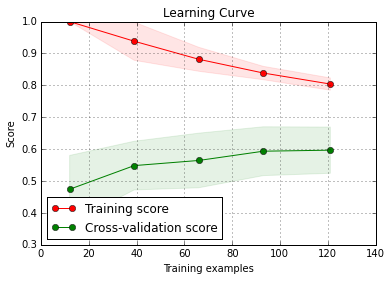

Accuracy 0.552631578947
F1 Score 0.555444724781


In [22]:
df = pd.read_pickle('Final Results.pickle')
X = np.array(df.drop(["CLUB_x","CLUB_y","Result"], 1 ))
X = preprocessing.scale(X)
y = np.array(df["Result"])
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=0)

cv = cross_validation.ShuffleSplit(X_train.shape[0], n_iter = 10, test_size=0.2, random_state=0)
SVM = svm.SVC(kernel='linear')
gammas = np.logspace(-6, -1, 10)
classifier = grid_search.GridSearchCV(estimator=SVM, cv=cv, param_grid = dict(gamma=gammas))
classifier.fit(X_train, y_train)

estimator = svm.SVC(kernel='linear', gamma = classifier.best_estimator_.gamma)
plot_learning_curve(estimator,'Learning Curve',X_train, y_train, cv=cv)
plt.show()

estimator.fit(X_train, y_train)
print('Accuracy '+str(estimator.score(X_test, y_test)))
y_pred = estimator.predict(X_test)
print('F1 Score '+str(metrics.f1_score(y_test, y_pred)))